<b>ML1.1 Парная регрессия<br>
ПИ19-3 Деменчук Георгий</b>

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Импортируем данные

In [2]:
yandex = pd.read_csv("./data/YNDX_101001_171001.txt")
mvid = pd.read_csv("./data/MVID_101001_171001.txt")
sber = pd.read_csv("./data/SBER_101001_171001.txt")

Смотрим на структуру данных

In [3]:
yandex.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<CLOSE>,<VOL>
0,YNDX,D,20140604,0,1170.0,35146
1,YNDX,D,20140605,0,1145.1,24973
2,YNDX,D,20140606,0,1163.0,7889
3,YNDX,D,20140609,0,1172.1,7304
4,YNDX,D,20140610,0,1170.0,3207


In [4]:
mvid.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<CLOSE>,<VOL>
0,MVID,D,20101001,0,194.38,19406
1,MVID,D,20101004,0,190.00,31039
2,MVID,D,20101005,0,187.00,17651
3,MVID,D,20101006,0,190.04,36482
4,MVID,D,20101007,0,199.85,204248


In [5]:
sber.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<CLOSE>,<VOL>
0,SBER,D,20101001,0,89.09,332429890
1,SBER,D,20101004,0,89.88,194032721
2,SBER,D,20101005,0,91.97,198775753
3,SBER,D,20101006,0,91.20,210406027
4,SBER,D,20101007,0,90.40,145137617


Смотрим, чтоб не было null-значений

In [6]:
yandex.isna().sum()

<TICKER>    0
<PER>       0
<DATE>      0
<TIME>      0
<CLOSE>     0
<VOL>       0
dtype: int64

In [7]:
mvid.isna().sum()

<TICKER>    0
<PER>       0
<DATE>      0
<TIME>      0
<CLOSE>     0
<VOL>       0
dtype: int64

In [8]:
sber.isna().sum()

<TICKER>    0
<PER>       0
<DATE>      0
<TIME>      0
<CLOSE>     0
<VOL>       0
dtype: int64

Все вместе соединяем в одну таблицу

In [9]:
data = yandex.merge(mvid, on="<DATE>").merge(sber, on="<DATE>")

In [10]:
data.shape

(838, 16)

In [11]:
data.head()

,<TICKER>_x,<PER>_x,<DATE>,<TIME>_x,<CLOSE>_x,<VOL>_x,<TICKER>_y,<PER>_y,<TIME>_y,<CLOSE>_y,<VOL>_y,<TICKER>,<PER>,<TIME>,<CLOSE>,<VOL>
0,YNDX,D,20140604,0,1170.0,35146,MVID,D,0,260.02,99820,SBER,D,0,87.81,118784670
1,YNDX,D,20140605,0,1145.1,24973,MVID,D,0,259.81,84590,SBER,D,0,87.43,136633680
2,YNDX,D,20140606,0,1163.0,7889,MVID,D,0,258.99,99700,SBER,D,0,89.00,127884670
3,YNDX,D,20140609,0,1172.1,7304,MVID,D,0,254.45,63820,SBER,D,0,88.89,84744280
4,YNDX,D,20140610,0,1170.0,3207,MVID,D,0,256.00,72120,SBER,D,0,88.99,85841300


Выделяем Y для каждой акции

In [12]:
Y_yndx = data["<CLOSE>_x"]
Y_mvid = data["<CLOSE>_y"]
Y_sber = data["<CLOSE>"]

Выделяем X для каждой акции

In [13]:
X_yndx = yandex.drop("<CLOSE>", axis=1)
X_mvid = mvid.drop("<CLOSE>", axis=1)
X_sber = sber.drop("<CLOSE>", axis=1)

Выводим отфильтрованные данные

In [14]:
X_yndx.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<VOL>
0,YNDX,D,20140604,0,35146
1,YNDX,D,20140605,0,24973
2,YNDX,D,20140606,0,7889
3,YNDX,D,20140609,0,7304
4,YNDX,D,20140610,0,3207


In [15]:
X_mvid.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<VOL>
0,MVID,D,20101001,0,19406
1,MVID,D,20101004,0,31039
2,MVID,D,20101005,0,17651
3,MVID,D,20101006,0,36482
4,MVID,D,20101007,0,204248


In [16]:
X_sber.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<VOL>
0,SBER,D,20101001,0,332429890
1,SBER,D,20101004,0,194032721
2,SBER,D,20101005,0,198775753
3,SBER,D,20101006,0,210406027
4,SBER,D,20101007,0,145137617


In [17]:

class MyRegression:
    """
    Класс регрессии, по сути реализует формулу
    y = b0 + b1 * x
    """
    def __init__(self):
        #Коэффы
        self.b0 = 0
        self.b1 = 0
    
    def fit(self, X, Y, alpha = 0.000005, accuracy = 0.0001, max_steps = 5000):
        """Метод для самого обучения"""
        
        steps, errors = [], []
        dJ = 1
        step = 0
        
        #Ошибки
        old_err = self.err(X, Y)
        new_err = self.err(X, Y) - 1
        
        #Специальные ограничения, чтоб вечно не обучалось
        while dJ > accuracy and (step < max_steps):
            
            dJ0 = sum(self.predict(X)-Y) / len(X)
            dJ1 = sum((self.predict(X) - Y) * X) / len(X)
            
            self.b0 -= alpha * dJ0
            self.b1 -= alpha * dJ1
            
            #Новая ошибка становится старой
            old_err = new_err
            new_err = self.err(X, Y)
            
            # Обновляем dj, как флаг выхода из цикла
            dJ = abs(old_err - new_err)
            print(dJ)
            
            step += 1
            steps.append(step)
            errors.append(new_err)
            
        return steps, errors
    
    def predict(self, x):
        """Метод предсказания данных"""
        return self.b0 + self.b1 * x
    
    def err(self, X, Y):
        """Функция ошибки"""
        return sum((self.predict(X) - Y) ** 2) / (2 * len(X))

# SBER x YANDEX

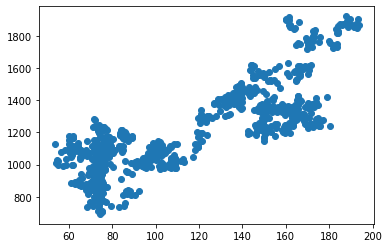

In [18]:
plt.figure()
plt.scatter(Y_sber, Y_yndx)
plt.show()

In [19]:
model = MyRegression()
steps, errors = model.fit(Y_sber, Y_yndx)
model.predict(Y_sber)

100554.8968001476
86569.1689930011
74527.91234348482
64161.52331391891
55237.03771908471
47553.895314797
40939.43260125432
35245.002550807054
30342.63405864613
26122.156044161704
22488.721572797192
19360.67635791967
16667.723741481663
14349.344915021298
12353.438878585788
10635.151573331357
9155.867874849064
7882.343794269662
6785.959385058231
5842.075566060856
5029.480406662064
4329.912430403609
3727.6502242536226
3209.1591307974522
2762.787083458861
2378.5027492439476
2047.670094278379
1762.8543059499352
1517.6547101311007
1306.5609286282197
1124.8290442816287
968.374990764627
833.6827712350205
717.7254432267873
617.8970940775398
531.9542781721539
457.96559991826507
394.26830943375535
339.43093551580387
292.2211161439045
251.57790356982878
216.58792160544544
186.46483929138776
160.53169965577035
138.20570644040708
118.98512690162534
102.43801635355703
88.19251106380398
75.92847134641852
65.37028705361809
56.28068377926684
48.45539058531358
41.718549413461005
35.91876302111268
30.9256

0.021680524896510178
0.021680500758520793
0.021680476515030023
0.021680452322470956
0.021680428042600397
0.02168040384640335
0.021680379708413966
0.021680355435819365
0.021680331261450192
0.021680307101632934
0.021680282850866206
0.021680258603737457
0.021680234400264453
0.02168021025136113
0.021680186026060255
0.02168016176801757
0.021680137542716693
0.021680113444745075
0.021680089135770686
0.021680064979591407
0.021680040805222234
0.021680016470781993
0.02167999238372431
0.021679968154785456
0.021679943907656707
0.02167991971509764
0.021679895518900594
0.021679871271771844
0.02167984709740267
0.021679822901205625
0.021679798664990813
0.02167977448698366
0.02167975030533853
0.021679725992726162
0.021679701840184862
0.02167967766217771
0.02167965344415279
0.021679629218851915
0.021679604971723165
0.02167958083373378
0.02167955649929354
0.02167953247044352
0.0216795082524186
0.021679483957996126
0.021679459707229398
0.02167943557651597
0.021679411351215094
0.021679387100448366
0.021679

0.021667891607648926
0.021667867400537943
0.021667843149771215
0.021667819055437576
0.021667794928362127
0.021667770684871357
0.021667746317689307
0.021667722288839286
0.021667698078090325
0.02166767385278945
0.02166764972207602
0.021667625464033335
0.021667601256922353
0.021667577060725307
0.02166755293001188
0.02166752865014132
0.021667504555807682
0.021667480341420742
0.021667456083378056
0.021667431923560798
0.021667407741915667
0.02166738351661479
0.02166735936407349
0.021667335167876445
0.02166731093529961
0.02166728675365448
0.021667262579285307
0.021667238343070494
0.021667214208719088
0.021667189972504275
0.021667165787221165
0.021667141456418904
0.021667117533070268
0.021667093165888218
0.021667069057002664
0.021667044842615724
0.0216670205736591
0.02166699645749759
0.021666972254024586
0.02166694806146552
0.02166692380706081
0.02166689965815749
0.021666875512892148
0.021666851273039356
0.02166682704773848
0.021666802906111116
0.021666778662620345
0.0216667544664233
0.0216667

0.021656474771589274
0.021656450498994673
0.021656426401023054
0.021656402175722178
0.02165637798316311
0.02165635385972564
0.02165632955802721
0.021656305561918998
0.021656281274772482
0.021656257016729796
0.021656232936948072
0.021656208780768793
0.021656184562743874
0.02165616036654683
0.02165613615215989
0.021656112039636355
0.02165608781433548
0.021656063618138433
0.02165603944013128
0.021656015331245726
0.02165599104773719
0.021655966975231422
0.021655942688084906
0.021655918568285415
0.021655894386640284
0.021655870164977387
0.021655846037901938
0.02165582181987702
0.021655797620041994
0.02165577351115644
0.021655749318597373
0.02165572508602054
0.021655700908013387
0.02165567671545432
0.02165565259565483
0.02165562834852608
0.02165560422145063
0.02165557998159784
0.021655555901816115
0.02165553164377343
0.02165550748759415
0.02165548327320721
0.021655459127941867
0.021655434975400567
0.021655410739185754
0.02165538650297094
0.021655362372257514
0.02165533829247579
0.02165531399

0.021644362994265975
0.02164433876168914
0.021644314725563163
0.02164429043114069
0.021644266260409495
0.02164424211878213
0.021644218017172534
0.021644193733663997
0.02164416963569238
0.02164414542130544
0.021644121348799672
0.021644097090756986
0.021644073007337283
0.02164404871291481
0.021644024567649467
0.02164400052788551
0.021643976229825057
0.021643952106387587
0.021643927964760223
0.021643903779477114
0.02164387957600411
0.021643855379807064
0.021643831369146938
0.02164380705653457
0.02164378296583891
0.021643758769641863
0.021643734584358754
0.021643710424541496
0.02164368625744828
0.021643662057613255
0.021643638021487277
0.021643613712512888
0.021643589578161482
0.02164356542925816
0.02164354127671686
0.0216435170659679
0.021643492964358302
0.021643468702677637
0.021643444615619956
0.021643420364853228
0.02164339629962342
0.021643372074322542
0.021643348012730712
0.021643323645548662
0.021643299605784705
0.021643275369569892
0.021643251260684337
0.021643227144522825
0.021643

0.021632571988448035
0.021632547799526947
0.021632523745211074
0.021632499472616473
0.021632475403748685
0.021632451225741534
0.02163242708775215
0.021632402858813293
0.021632378800859442
0.021632354604662396
0.021632330368447583
0.021632306248648092
0.021632282168866368
0.021632257998135174
0.021632233871059725
0.02163220957663725
0.021632185569615103
0.02163216136250412
0.021632137191772927
0.02163211305742152
0.021632088883052347
0.021632064726873068
0.021632040592521662
0.021632016450894298
0.021631992207403528
0.021631968145811697
0.021631943996908376
0.02163191982981516
0.021631895579048432
0.021631871568388306
0.021631847390381154
0.021631823165080277
0.021631799048918765
0.02163177482361789
0.021631750740198186
0.021631726565829013
0.02163170247877133
0.021631678195262793
0.021631654151860857
0.021631629919284023
0.021631605799484532
0.021631581628753338
0.0216315574652981
0.021631533396430314
0.021631509236613056
0.021631485014950158
0.02163146092061652
0.021631436651659897
0.

0.02162158424471272
0.021621559899358544
0.021621535888698418
0.02162151173251914
0.021621487565425923
0.02162146342016058
0.021621439260343323
0.02162141514054383
0.021621391031658277
0.021621366846375167
0.021621342730213655
0.021621318555844482
0.021621294396027224
0.021621270338073373
0.021621246090944624
0.02162122206937056
0.02162119776039617
0.021621173782477854
0.02162114958264283
0.02162112536825589
0.02162110139397555
0.021621077143208822
0.021621052983391564
0.02162102890360984
0.021621004649205133
0.021620980634907028
0.02162095638777828
0.021620932337100385
0.02162090813362738
0.021620884002913954
0.021620859843096696
0.021620835716021247
0.021620811621687608
0.021620787392748753
0.021620763356622774
0.02162073912040796
0.021620715011522407
0.021620690866257064
0.021620666761009488
0.021620642619382124
0.021620618397719227
0.021620594314299524
0.021620570194500033
0.021620545994665008
0.021620521842123708
0.02162049780599773
0.02162047352976515
0.02162044946453534
0.021620

0.02160973313220893
0.021609709077893058
0.021609684907161864
0.021609660820104182
0.021609636682114797
0.021609612533211475
0.02160958839886007
0.021609564264508663
0.021609540155623108
0.021609515981253935
0.021609491956041893
0.021609467756206868
0.021609443541819928
0.02160941962938523
0.021609395389532438
0.0216093712260772
0.021609347066259943
0.021609323030133964
0.02160929885940277
0.021609274692309555
0.021609250696201343
0.02160922634357121
0.021609202351100976
0.02160917824221542
0.02160915412605391
0.021609129900753032
0.021609105810057372
0.02160908171936171
0.021609057617752114
0.021609033403365174
0.021609009301755577
0.02160898517468013
0.02160896104760468
0.02160893695690902
0.02160891271341825
0.02160888873549993
0.02160886449564714
0.02160884036857169
0.0216088163688255
0.021608792139886646
0.02160876797279343
0.021608743900287664
0.021608719780488173
0.021608695689792512
0.021608671413559932
0.02160864744655555
0.02160862323216861
0.02160859914511093
0.0216085749379

0.02159784045215929
0.02159781635782565
0.02159779226349201
0.02159776817643433
0.021597744031168986
0.021597719874989707
0.021597695820673835
0.021597671628114767
0.021597647613816662
0.021597623424895573
0.02159759928690619
0.021597575287159998
0.021597551076411037
0.021597527029371122
0.021597502865915885
0.021597478720650543
0.021597454702714458
0.021597430441033794
0.021597406437649624
0.021597382274194388
0.021597358194412664
0.021597334067337215
0.02159730989660602
0.02159728580591036
0.021597261726128636
0.021597237577225314
0.021597213508357527
0.02159718931216048
0.021597165276034502
0.021597141112579266
0.021597117025521584
0.02159709291663603
0.02159706878956058
0.02159704464065726
0.02159702054632362
0.021596996444714023
0.021596972263068892
0.021596948245132808
0.021596924070763635
0.0215968999582401
0.021596875889372313
0.021596851758658886
0.021596827606117586
0.021596803569991607
0.02159677937379456
0.021596755294012837
0.021596731148747494
0.021596707025310025
0.02159

0.02158626771051786
0.021586243597994326
0.021586219456366962
0.02158619531110162
0.02158617130407947
0.02158614727159147
0.021586123024462722
0.021586099024716532
0.02158607478122576
0.02158605072690989
0.021586026698059868
0.021586002607364208
0.02158597835659748
0.021585954400507035
0.02158593026251765
0.021585906084510498
0.021585882066574413
0.021585857917671092
0.021585833808785537
0.0215858097653836
0.021585785667411983
0.021585761445749085
0.0215857374969346
0.021585713293461595
0.0215856893119053
0.021585665046586655
0.021585640948615037
0.021585616901575122
0.021585592759947758
0.021585568745649653
0.02158554460402229
0.02158552050241269
0.02158549644445884
0.021585472317383392
0.02158544808116858
0.02158542407414643
0.02158540001619258
0.021585375885479152
0.021585351762041682
0.021585327700449852
0.021585303504252806
0.02158527945721289
0.021585255446552765
0.021585231283097528
0.0215852071523841
0.021585183018032694
0.021585158927337034
0.02158513484755531
0.02158511073139

0.021573882037046133
0.02157385786267696
0.021573833848378854
0.021573809746769257
0.021573785717919236
0.021573761558101978
0.021573737441940466
0.021573713438556297
0.021573689289652975
0.021573665169853484
0.021573641199211124
0.021573616988462163
0.02157359299962991
0.021573568858002545
0.021573544705461245
0.021573520727542927
0.02157349659319152
0.021573472451564157
0.021573448419076158
0.021573424372036243
0.021573400172201218
0.021573376219748752
0.021573352023551706
0.021573327998339664
0.02157330388945411
0.021573279755102703
0.021573255664407043
0.02157323164283298
0.021573207406618167
0.021573183523287298
0.02157315936710802
0.02157313530551619
0.021573111047473503
0.02157308714959072
0.021573062946117716
0.02157303884087014
0.021573014921159483
0.02157299075042829
0.021572966546955286
0.021572942605416756
0.021572918431047583
0.021572894325800007
0.021572870264208177
0.021572846279013902
0.0215728220755409
0.021572797984845238
0.021572773875959683
0.021572749839833705
0.02

0       879.536158
1       875.737399
2       891.432272
3       890.332631
4       891.332304
          ...     
833    1926.494153
834    1938.090365
835    1920.696047
836    1924.394839
837    1931.092651
Name: <CLOSE>, Length: 838, dtype: float64

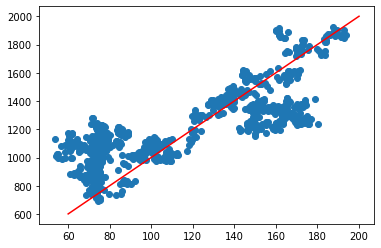

In [20]:


X0 = np.linspace(60, 200, 100)
Y0 = model.predict(X0)
plt.figure()
plt.scatter(Y_sber, Y_yndx)
plt.plot(X0, Y0, 'r')
plt.show()

In [21]:
print(f"{model.err(Y_sber, Y_yndx)=}")

model.err(Y_sber, Y_yndx)=31476.217880006338


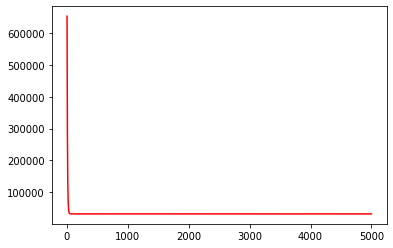

In [22]:
plt.figure()
plt.plot(steps, errors, "r")
plt.show()

# SBER x MVID

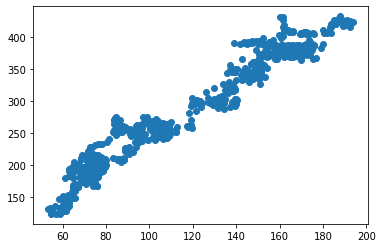

In [23]:
plt.figure()
plt.scatter(Y_sber, Y_mvid)
plt.show()

In [24]:
model = MyRegression()
steps, errors = model.fit(Y_sber, Y_mvid)
model.predict(Y_sber)

5824.332101056396
5015.062861634899
4317.497283637673
3716.958953990852
3199.9519560098925
2754.857575242644
2371.6731917347097
2041.7874908384729
1757.7869408695205
1513.2891885766148
1302.799628317689
1121.5879216148287
965.5816921097967
831.2750069226595
715.6495877121779
616.1069808123766
530.4101621018676
456.63326429070503
393.1182968445337
338.4378859113631
291.36319690433174
250.83631886353942
215.94648998993785
185.90963006689435
160.05071980095795
137.7886310921067
118.62306732380262
102.12332018143434
87.91859033088394
75.68965443350112
65.1616912299902
56.09810547366669
48.29521091806373
41.57765286953986
35.79446743575477
30.815688909399057
26.529429044767028
22.83936258973455
19.662562565326994
16.92763664513717
14.573122753340101
12.546107825529475
10.801038691775773
9.298698358803676
8.005324685276037
6.891851644138399
5.933256120880117
5.107995568297213
4.397523880158417
3.7858746039759126
3.25930212641822
2.8059727677169235
2.4156988430026445
2.079709714150283
1.79045

0.00014586053890752737
0.00014586037497110738
0.00014586021285367679
0.0001458600498835949
0.00014585988731141697
0.0001458597237160575
0.0001458595615986269
0.00014585939851485819
0.0001458592355447763
0.00014585907234732076
0.0001458589102867336
0.00014585874708927804
0.00014585858377813565
0.00014585842097858404
0.00014585825795165874
0.00014585809617528867
0.00014585793286414628
0.00014585776972353415
0.0001458576070945128
0.00014585744310124937
0.00014585728149540955
0.00014585711784320665
0.00014585695600999316
0.00014585679230094684
0.0001458566297287689
0.00014585646704290411
0.00014585630435703933
0.00014585614076167985
0.00014585597807581507
0.00014585581533310688
0.00014585565281777235
0.00014585548939294313
0.00014585532642286125
0.0001458551637938399
0.00014585500116481853
0.00014585483836526691
0.0001458546749972811
0.00014585451242510317
0.0001458543497392384
0.00014585418728074728
0.0001458540234011707
0.0001458538612268967
0.00014585369768838063
0.0001458535354004198
0

0.00014577619623423743
0.0001457760337189029
0.0001457758700098566
0.00014577570811979967
0.00014577554509287438
0.00014577538189541883
0.00014577522046010927
0.00014577505641000243
0.0001457748938946679
0.00014577473098142946
0.00014577456892084228
0.0001457744056096999
0.00014577424263961802
0.00014577408023797034
0.00014577391755210556
0.00014577375435465
0.00014577359212353258
0.0001457734290966073
0.0001457732663538991
0.00014577310372487773
0.00014577294052742218
0.0001457727781257745
0.000145772614530415
0.00014577245258351468
0.00014577229001133674
0.00014577212664335093
0.00014577196475329401
0.00014577180036212667
0.00014577163824469608
0.00014577147624095232
0.00014577131327087045
0.000145771150357632
0.00014577098750123696
0.00014577082447431167
0.00014577066201582056
0.0001457704996710163
0.00014577033607565681
0.00014577017316241836
0.00014577001093130093
0.00014576984824543615
0.00014576968487745035
0.00014576952315792369
0.00014576935990362472
0.00014576919727460336
0.0

0.00014570866017038497
0.00014570849742767678
0.00014570833394600413
0.0001457081714306696
0.0001457080095406127
0.0001457078461726269
0.00014570768411203971
0.00014570752091458417
0.00014570735783081545
0.0001457071961112888
0.00014570703200433854
0.00014570687079640265
0.0001457067072578866
0.0001457065445720218
0.0001457063826819649
0.00014570621914344883
0.0001457060566281143
0.00014570589360118902
0.0001457057317111321
0.00014570556879789365
0.00014570540645308938
0.0001457052422324523
0.0001457050806834559
0.00014570491862286872
0.00014570475411801453
0.00014570459291007865
0.00014570443022421387
0.00014570426657201097
0.00014570410382930277
0.00014570394188240243
0.00014570377959444158
0.00014570361588539527
0.00014570345371112126
0.00014570329062735254
0.00014570312811201802
0.00014570296582405717
0.0001457028025697582
0.00014570263994073684
0.00014570247753908916
0.00014570231422794677
0.00014570215228104644
0.00014570198965202508
0.00014570182645456953
0.00014570166433713894


0.00014563253552069
0.0001456323736874765
0.00014563221020580386
0.0001456320484862772
0.00014563188523197823
0.0001456317230008608
0.0001456315599739355
0.0001456313983680957
0.00014563123511379672
0.00014563107220055826
0.00014563090996944084
0.0001456307468288287
0.0001456305846545547
0.00014563042168447282
0.00014563025911229488
0.0001456300976201419
0.00014562993379740874
0.00014562977099785712
0.00014562960950570414
0.00014562944613771833
0.00014562928367922723
0.0001456291208228322
0.00014562895825065425
0.00014562879670165785
0.00014562863304945495
0.0001456284701930599
0.00014562830818931616
0.00014562814573082505
0.00014562798247652609
0.0001456278197906613
0.00014562765835535174
0.000145627494589462
0.00014562733230150116
0.0001456271699566969
0.0001456270069297716
0.00014562684458496733
0.00014562668195594597
0.0001456265193269246
0.00014562635675474667
0.00014562619429625556
0.00014562603092826976
0.00014562586932242993
0.00014562570595444413
0.00014562554383701354
0.00014

0.00014556344126503973
0.00014556327852233153
0.0001455631150975023
0.0001455629535485059
0.0001455627904647372
0.00014556262851783686
0.00014556246520669447
0.00014556230291873362
0.00014556214085814645
0.0001455619780017514
0.00014556181542957347
0.00014556165268686527
0.00014556149022837417
0.00014556132771303965
0.00014556116548192222
0.00014556100273921402
0.00014556084011019266
0.00014556067702642395
0.0001455605153637407
0.00014556035273471934
0.0001455601898783243
0.00014556002747667662
0.0001455598652455592
0.00014555970233232074
0.00014555954072648092
0.0001455593767332175
0.000145559214900004
0.00014555905198676555
0.00014555888975564812
0.00014555872775190437
0.0001455585641565449
0.0001455584026643919
0.0001455582392964061
0.00014555807723581893
0.00014555791466364099
0.00014555775180724595
0.00014555758934875485
0.00014555742751554135
0.00014555726392018187
0.0001455571024848723
0.00014555693951479043
0.00014555677660155197
0.00014555661442727796
0.00014555645191194344
0.

0.00014548917999945843
0.00014548901691568972
0.00014548885542353673
0.00014548869245345486
0.0001454885298244335
0.00014548836730909898
0.00014548820468007762
0.00014548804273317728
0.00014548788010415592
0.0001454877175888214
0.00014548755507348687
0.0001454873924444655
0.00014548723078178227
0.00014548706769801356
0.00014548690575111323
0.00014548674283787477
0.0001454865802088534
0.0001454864180345794
0.00014548625563293172
0.0001454860934586577
0.00014548593077279293
0.00014548576757533738
0.00014548560631055807
0.00014548544282888543
0.00014548528048408116
0.00014548511887824134
0.00014548495636290681
0.000145484792994921
0.00014548463047958649
0.00014548446921480718
0.00014548430584682137
0.00014548414389992104
0.00014548398144142993
0.0001454838185850349
0.00014548365629707405
0.00014548349435017371
0.00014548333109587475
0.00014548316886475732
0.00014548300657679647
0.0001454828445162093
0.00014548268131875375
0.00014548251942869683
0.00014548235634492812
0.0001454821941138107

0.0001454014802675374
0.0001454013180932634
0.00014540115580530255
0.00014540099294890751
0.000145400830433573
0.00014540066877088975
0.00014540050602818155
0.00014540034379706412
0.00014540018145225986
0.00014540001933482927
0.0001453998564215908
0.00014539969401994313
0.0001453995320730428
0.00014539936944402143
0.0001453992074971211
0.0001453990456639076
0.00014539888178433102
0.00014539872063323855
0.00014539855766315668
0.00014539839543203925
0.00014539823337145208
0.00014539807091296097
0.00014539790828393961
0.00014539774605282219
0.00014539758387854818
0.00014539742107899656
0.0001453972587910357
0.00014539709735572615
0.00014539693381721008
0.00014539677255243078
0.00014539660884338446
0.0001453964471238578
0.00014539628551801798
0.00014539612232056243
0.0001453959598052279
0.00014539579848360518
0.0001453956352293062
0.0001453954733392493
0.0001453953109376016
0.0001453951481948934
0.00014539498619114966
0.00014539482373265855
0.0001453946614446977
0.00014539449909989344
0.00

0.00014532162214209166
0.0001453214597972874
0.0001453212979640739
0.00014532113573295646
0.00014532097344499562
0.00014532081075913084
0.0001453206485280134
0.0001453204866379565
0.00014532032440683906
0.0001453201614936006
0.0001453199999446042
0.00014531983725873943
0.0001453196753118391
0.00014531951239860064
0.00014531935096329107
0.00014531918839111313
0.0001453190255915615
0.00014531886415625195
0.00014531870107248324
0.0001453185397508605
0.00014531837672393522
0.00014531821460650463
0.00014531805311435164
0.00014531788957583558
0.00014531772802683918
0.00014531756573887833
0.00014531740310985697
0.00014531724144717373
0.00014531707870446553
0.00014531691732599938
0.00014531675424223067
0.000145316591840583
0.00014531642966630898
0.0001453162678899389
0.00014531610469248335
0.00014531594376876455
0.00014531578045762217
0.00014531561907915602
0.0001453154559953873
0.00014531529416217381
0.00014531513056681433
0.0001453149707231205
0.00014531480661617024
0.00014531464535139094
0.

0.00014524488943834513
0.00014524472732091454
0.00014524456526032736
0.00014524440348395729
0.0001452442407412491
0.00014524407907856585
0.00014524391662007474
0.00014524375450264415
0.0001452435922146833
0.00014524343021093955
0.00014524326832088263
0.00014524310552133102
0.00014524294294915308
0.00014524278122962642
0.00014524261951009976
0.0001452424568810784
0.00014524229516155174
0.0001452421319640962
0.00014524197081300372
0.0001452418086387297
0.00014524164538443074
0.00014524148468808562
0.0001452413215474735
0.0001452411585205482
0.00014524099771051624
0.0001452408354793988
0.00014524067290722087
0.00014524051135822447
0.00014524034827445576
0.00014524018615702516
0.00014524002449434192
0.0001452398622632245
0.00014523969969104655
0.00014523953763045938
0.00014523937574040247
0.00014523921350928504
0.00014523905173291496
0.00014523888864914625
0.0001452387263611854
0.00014523856526693635
0.00014523840229685447
0.00014523824074785807
0.00014523807766408936
0.0001452379167972139

0.00014517127749513747
0.00014517111566192398
0.0001451709529760592
0.00014517079165443647
0.00014517062874119802
0.0001451704668511411
0.00014517030462002367
0.00014517014329840094
0.00014516998021463223
0.00014516981877932267
0.0001451696560934579
0.00014516949482867858
0.00014516933174490987
0.00014516917053697398
0.00014516900802163946
0.00014516884641579963
0.00014516868344571776
0.00014516852206725162
0.0001451683592677
0.00014516819692289573
0.00014516803634023745
0.000145167873426999
0.00014516771153694208
0.00014516754873739046
0.00014516738707470722
0.0001451672249004332
0.0001451670624419421
0.00014516690134769306
0.0001451667390028888
0.00014516657614649375
0.00014516641465434077
0.0001451662525937536
0.0001451660901921059
0.00014516592835889242
0.0001451657658435579
0.00014516560452193517
0.00014516544200660064
0.00014516527954810954
0.0001451651178854263
0.00014516495582483913
0.00014516479336634802
0.000145164631192074
0.00014516446987045128
0.00014516430695721283
0.0001

0      211.613717
1      210.698619
2      214.479420
3      214.214523
4      214.455338
          ...    
833    463.819604
834    466.613062
835    462.422875
836    463.313892
837    464.927354
Name: <CLOSE>, Length: 838, dtype: float64

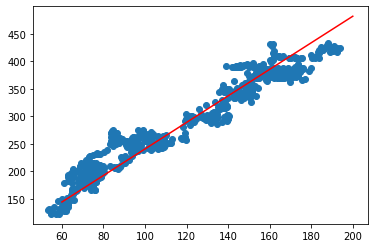

In [25]:
X0 = np.linspace(60, 200, 100)
Y0 = model.predict(X0)

plt.figure()
plt.scatter(Y_sber, Y_mvid)
plt.plot(X0, Y0, "r")
plt.show()

In [26]:
print(f"{model.err(Y_sber, Y_mvid)=}")

model.err(Y_sber, Y_mvid)=311.20100095713093


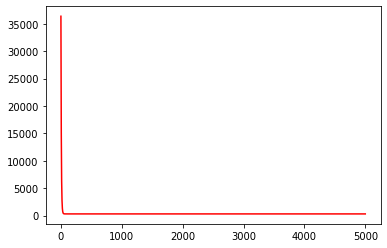

In [27]:
plt.figure()
plt.plot(steps, errors, "r")
plt.show()

Имплементация линейной регрессии в sklearn

In [28]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [29]:
Y_yndx = data["<CLOSE>_x"].values
Y_mvid = data["<CLOSE>_y"].values

In [30]:
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=110, tol=1e-1))
reg.fit(Y_yndx.reshape(-1, 1), Y_mvid)
reg.predict(Y_mvid.reshape(-1, 1))

array([ 3.37506460e+01,  3.36960485e+01,  3.34828580e+01,  3.23025108e+01,
        3.27054928e+01,  3.33918621e+01,  3.50453881e+01,  3.45774090e+01,
        3.63453299e+01,  3.75412764e+01,  3.73332857e+01,  3.64493253e+01,
        3.63427300e+01,  3.58253532e+01,  3.61191400e+01,  3.55237667e+01,
        3.63245308e+01,  3.55653648e+01,  3.60801418e+01,  3.25754986e+01,
        3.23545085e+01,  3.28978842e+01,  3.27314916e+01,  3.27028929e+01,
        3.09401718e+01,  3.00926097e+01,  3.18813297e+01,  3.12859563e+01,
        3.17435358e+01,  2.84520831e+01,  2.72847354e+01,  2.64657720e+01,
        2.65957662e+01,  2.65229694e+01,  2.66737627e+01,  2.60107924e+01,
        2.52126281e+01,  2.51658302e+01,  2.54232187e+01,  2.53530218e+01,
        2.36864964e+01,  2.36266990e+01,  2.36708971e+01,  2.21759640e+01,
        2.07486278e+01,  2.06160338e+01,  2.11360105e+01,  2.19835726e+01,
        2.21707642e+01,  2.18015807e+01,  2.12660047e+01,  2.09072207e+01,
        2.08292242e+01,  